In [11]:
import os
from tqdm import tqdm
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import rc_params
from skimage.feature import daisy
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.exposure import equalize_hist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc
%matplotlib inline

# load the labels using pandas
labels = pd.read_csv("data/train_labels.csv",index_col=0)

from create_feature_matrix import create_feature_matrix

In [2]:
bees_features = np.load("bees_features.npy")

In [3]:
ss = StandardScaler()
bees_stand = ss.fit_transform(bees_features)
bees_stand.shape

(3969, 168046)

In [4]:
pca = PCA(n_components=4e3)
bees_pca = pca.fit_transform(bees_stand)

/Users/johnwalters/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:301: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.noise_variance_ = explained_variance_[n_components:].mean()
/Users/johnwalters/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/johnwalters/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:308: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.components_ = components_[:n_components]
/Users/johnwalters/anaconda/lib/python2.7/site-packages/sklearn/decomposition/pca.py:309: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.explained_variance_ = explained_variance_[:n_components]
/Users/johnwalters/anaconda/lib/python2.7/site-package

In [7]:
X_train, X_test, y_train, y_test = train_test_split(bees_pca,labels.genus.values,test_size=.2,random_state=1234)

# SVM parameters often set on log scale
params_to_try = {'C': [10**i for i in range(0, 2)],'gamma': [10**i for i in range(-7, -5)],}

gs = GridSearchCV(svm.SVC(class_weight='auto', kernel='rbf', probability=True),param_grid=params_to_try,cv=3,scoring='roc_auc',n_jobs=-1)

gs.fit(X_train, y_train)

print "Best parameters:", gs.best_params_
print "Best score:", gs.best_score_

Best parameters: {'C': 1, 'gamma': 1e-06}
Best score: 0.696796977623


In [8]:
preds = gs.best_estimator_.predict_proba(X_test)

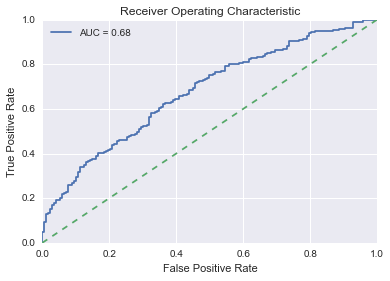

In [9]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,preds[:, 1],pos_label=1)

roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate,label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [12]:
sf = pd.read_csv("data/SubmissionFormat.csv", index_col=0)

def make_predictions(submission_format_df,output_filepath="my_submission.csv"):
    prediction_df = submission_format_df.copy()
    
    # create features
    test_features = create_feature_matrix(submission_format_df)
    test_features_stand = ss.transform(test_features)   
    test_features_pca = pca.transform(test_features_stand)
    
    # predict with the best estimator from the grid search
    preds = gs.best_estimator_.predict_proba(test_features_pca)
    
    # copy the predictions to the dataframe with the ids and
    # write it out to a file
    prediction_df.genus = preds[:, 1]
    prediction_df.to_csv(output_filepath)
    
    return prediction_df
    
pred_df = make_predictions(sf, output_filepath="raw_hog_daisy_rbf.csv")
pred_df.head()

,genus
id,
2783,0.814626
2175,0.880654
4517,0.881033
2831,0.745186
3556,0.818123
